In [1]:
# Dataset obtained from : https://www.kaggle.com/elroyme/singapore-energy-market
# For this project, I will attempt to predict the demand of electricity required in each period. Note that each period refers 
# to each half an hour that the market clearing engine runs. This means that there are 48 period in a day. The motivation behind the 
# project is to enable for better planning of the energy distribution .

In [2]:
# Following definitions are obtained from https://www.emcsg.com/glossary
# Load Curtailment(LCP) - provide commercial and industrial building owners with reduced electrical rates in exchange for an 
# agreement to curtail energy use at the request of the utility.
# Total curtailed load(TCL) - Sum of load scheduled to be curtailed across all load registered facilities for each 0.5 hr period
# USEP - weighted average of the nodal prices at all off-take nodes

In [3]:
# PRE-PROCESSING
import pandas as pd
from pandas import DataFrame
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# pre-process april 2016 data since this is the only month where the data is split into 2 different files 
# I am inserting a few columns (namely LCP and TCL) into certain datasets since I do not know if those columns contain 
# anything other than the value 0. Ultimately, I will combine all the datasets into one large dataframe before feeding it 
# into a model.
apr1_to_apr27 = pd.read_csv("Downloads/usep-2015-2020/usep-raw/2016/USEP_01-Apr-2016_to_27-Apr-2016.csv")
apr28_to_apr30 = pd.read_csv("Downloads/usep-2015-2020/usep-raw/2016/USEP_28-Apr-2016_to_30-Apr-2016.csv")

# From the dataset, we can see that PRICE ($/MWh) is referring to the same thing as USEP ($/MWH). Hence, I am just replacing
# the column name PRICE with USEP
apr1_to_apr27.insert(3, "USEP ($/MWh)", apr1_to_apr27['PRICE ($/MWh)'])
apr1_to_apr27 = apr1_to_apr27.drop(['PRICE ($/MWh)'], axis = 1)
apr1_to_apr27.insert(4, "LCP ($/MWh)", 0)
apr1_to_apr27.insert(6, "TCL (MW)", 0.0)
USEP_Apr_2016 = pd.concat([apr1_to_apr27, apr28_to_apr30], ignore_index = True)
USEP_Apr_2016

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),LCP ($/MWh),DEMAND (MW),TCL (MW)
0,USEP,01 Apr 2016,1,40.76,0.0,5251.739,0.0
1,USEP,01 Apr 2016,2,40.44,0.0,5144.914,0.0
2,USEP,01 Apr 2016,3,40.20,0.0,5057.233,0.0
3,USEP,01 Apr 2016,4,39.20,0.0,4997.554,0.0
4,USEP,01 Apr 2016,5,38.54,0.0,4945.567,0.0
...,...,...,...,...,...,...,...
1435,USEP,30 Apr 2016,44,43.87,0.0,5567.329,0.0
1436,USEP,30 Apr 2016,45,42.61,0.0,5478.540,0.0
1437,USEP,30 Apr 2016,46,42.36,0.0,5399.164,0.0
1438,USEP,30 Apr 2016,47,41.85,0.0,5313.835,0.0


In [4]:
months = ["Jan", "Feb", "Mar", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
head = "Downloads/usep-2015-2020/usep-raw/2016/USEP_"
tail = "-2016.csv"
year_2016 = DataFrame([])
for i in months:
    data = pd.read_csv(head + i + tail)
    if "PRICE ($/MWh)" in data:
        data.insert(3, "USEP ($/MWh)", data['PRICE ($/MWh)'])
        data = data.drop(['PRICE ($/MWh)'], axis = 1)
    if "LCP ($/MWh)" not in data:
        data.insert(4, "LCP ($/MWh)", 0)
    if "TCL (MW)" not in data:
        data.insert(4, "TCL (MW)", 0)
    year_2016 = pd.concat([year_2016, data], ignore_index = True) 

year_2016 = pd.concat([USEP_Apr_2016,year_2016], ignore_index = True)
# Rearranging the columns
year_2016 = year_2016[["INFORMATION TYPE", "DATE", "PERIOD", "USEP ($/MWh)", "TCL (MW)", "DEMAND (MW)", "LCP ($/MWh)"]]
year_2016 

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,USEP,01 Apr 2016,1,40.76,0.0,5251.739,0.0
1,USEP,01 Apr 2016,2,40.44,0.0,5144.914,0.0
2,USEP,01 Apr 2016,3,40.20,0.0,5057.233,0.0
3,USEP,01 Apr 2016,4,39.20,0.0,4997.554,0.0
4,USEP,01 Apr 2016,5,38.54,0.0,4945.567,0.0
...,...,...,...,...,...,...,...
17563,USEP,31 Dec 2016,44,69.96,0.0,5433.353,0.0
17564,USEP,31 Dec 2016,45,68.54,0.0,5328.218,0.0
17565,USEP,31 Dec 2016,46,67.84,0.0,5234.936,0.0
17566,USEP,31 Dec 2016,47,65.85,0.0,5134.482,0.0


In [5]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
head = "Downloads/usep-2015-2020/usep-raw/2017/USEP_"
tail = "-2017.csv"
year_2017 = DataFrame([])
for i in months:
    data = pd.read_csv(head + i + tail)
    if "PRICE ($/MWh)" in data:
        data.insert(3, "USEP ($/MWh)", data['PRICE ($/MWh)'])
        data = data.drop(['PRICE ($/MWh)'], axis = 1)
    if "LCP ($/MWh)" not in data:
        data.insert(4, "LCP ($/MWh)", 0)
    if "TCL (MW)" not in data:
        data.insert(4, "TCL (MW)", 0)
    year_2017 = pd.concat([year_2017, data], ignore_index = True) 

# Rearranging the columns
year_2017 = year_2017[["INFORMATION TYPE", "DATE", "PERIOD", "USEP ($/MWh)", "TCL (MW)", "DEMAND (MW)", "LCP ($/MWh)"]]
year_2017 

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,USEP,01 Jan 2017,1,79.13,0.0,4920.191,0.0
1,USEP,01 Jan 2017,2,78.03,0.0,4829.757,0.0
2,USEP,01 Jan 2017,3,76.47,0.0,4760.211,0.0
3,USEP,01 Jan 2017,4,76.44,0.0,4733.358,0.0
4,USEP,01 Jan 2017,5,75.99,0.0,4714.507,0.0
...,...,...,...,...,...,...,...
17515,USEP,31 Dec 2017,44,84.47,0.0,5456.444,0.0
17516,USEP,31 Dec 2017,45,81.34,0.0,5348.664,0.0
17517,USEP,31 Dec 2017,46,80.71,0.0,5254.299,0.0
17518,USEP,31 Dec 2017,47,84.45,0.0,5167.751,0.0


In [7]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
head = "Downloads/usep-2015-2020/usep-raw/2018/USEP_"
tail = "-2018.csv"
year_2018 = DataFrame([])
for i in months:
    data = pd.read_csv(head + i + tail)
    if "PRICE ($/MWh)" in data:
        data.insert(3, "USEP ($/MWh)", data['PRICE ($/MWh)'])
        data = data.drop(['PRICE ($/MWh)'], axis = 1)
    if "LCP ($/MWh)" not in data:
        data.insert(4, "LCP ($/MWh)", 0)
    if "TCL (MW)" not in data:
        data.insert(4, "TCL (MW)", 0)
    year_2018 = pd.concat([year_2018, data], ignore_index = True) 

# Rearranging the columns
year_2018 = year_2018[["INFORMATION TYPE", "DATE", "PERIOD", "USEP ($/MWh)", "TCL (MW)", "DEMAND (MW)", "LCP ($/MWh)"]]
year_2018 

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,USEP,01 Jan 2018,1,85.43,0.0,5007.524,0.0
1,USEP,01 Jan 2018,2,83.45,0.0,4892.041,0.0
2,USEP,01 Jan 2018,3,80.56,0.0,4799.713,0.0
3,USEP,01 Jan 2018,4,80.56,0.0,4766.702,0.0
4,USEP,01 Jan 2018,5,80.55,0.0,4741.196,0.0
...,...,...,...,...,...,...,...
17515,USEP,31 Dec 2018,44,78.20,0.0,5740.176,0.0
17516,USEP,31 Dec 2018,45,75.69,0.0,5593.397,0.0
17517,USEP,31 Dec 2018,46,75.68,0.0,5461.583,0.0
17518,USEP,31 Dec 2018,47,75.58,0.0,5353.023,0.0


In [8]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
head = "Downloads/usep-2015-2020/usep-raw/2019/USEP_"
tail = "-2019.csv"
year_2019 = DataFrame([])
for i in months:
    data = pd.read_csv(head + i + tail)
    if "PRICE ($/MWh)" in data:
        data.insert(3, "USEP ($/MWh)", data['PRICE ($/MWh)'])
        data = data.drop(['PRICE ($/MWh)'], axis = 1)
    if "LCP ($/MWh)" not in data:
        data.insert(4, "LCP ($/MWh)", 0)
    if "TCL (MW)" not in data:
        data.insert(4, "TCL (MW)", 0)
    year_2019 = pd.concat([year_2019, data], ignore_index = True) 

# Rearranging the columns
year_2019 = year_2019[["INFORMATION TYPE", "DATE", "PERIOD", "USEP ($/MWh)", "TCL (MW)", "DEMAND (MW)", "LCP ($/MWh)"]]
year_2019 

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,USEP,01 Jan 2019,1,82.70,0.0,5201.890,0.0
1,USEP,01 Jan 2019,2,82.71,0.0,5150.461,0.0
2,USEP,01 Jan 2019,3,82.70,0.0,5106.794,0.0
3,USEP,01 Jan 2019,4,82.69,0.0,5075.841,0.0
4,USEP,01 Jan 2019,5,82.67,0.0,5044.147,0.0
...,...,...,...,...,...,...,...
17515,USEP,31 Dec 2019,44,75.60,0.0,5891.368,0.0
17516,USEP,31 Dec 2019,45,72.47,0.0,5763.008,0.0
17517,USEP,31 Dec 2019,46,69.45,0.0,5665.323,0.0
17518,USEP,31 Dec 2019,47,69.96,0.0,5571.594,0.0


In [9]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
head = "Downloads/usep-2015-2020/usep-raw/2020/USEP_"
tail = "-2020.csv"
year_2020 = DataFrame([])
for i in months:
    data = pd.read_csv(head + i + tail)
    if "PRICE ($/MWh)" in data:
        data.insert(3, "USEP ($/MWh)", data['PRICE ($/MWh)'])
        data = data.drop(['PRICE ($/MWh)'], axis = 1)
    if "LCP ($/MWh)" not in data:
        data.insert(4, "LCP ($/MWh)", 0)
    if "TCL (MW)" not in data:
        data.insert(4, "TCL (MW)", 0)
    year_2020 = pd.concat([year_2020, data], ignore_index = True) 

# Rearranging the columns
year_2020 = year_2020[["INFORMATION TYPE", "DATE", "PERIOD", "USEP ($/MWh)", "TCL (MW)", "DEMAND (MW)", "LCP ($/MWh)"]]
year_2020 

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,USEP,01 Jan 2020,1,70.56,0.0,5393.623,0.0
1,USEP,01 Jan 2020,2,75.39,0.0,5308.014,0.0
2,USEP,01 Jan 2020,3,72.72,0.0,5219.747,0.0
3,USEP,01 Jan 2020,4,70.49,0.0,5164.093,0.0
4,USEP,01 Jan 2020,5,70.48,0.0,5131.699,0.0
...,...,...,...,...,...,...,...
17563,USEP,31 Dec 2020,44,55.36,0.0,5876.414,0.0
17564,USEP,31 Dec 2020,45,69.15,0.0,5772.725,0.0
17565,USEP,31 Dec 2020,46,55.35,0.0,5661.123,0.0
17566,USEP,31 Dec 2020,47,68.12,0.0,5593.243,0.0


In [10]:
full_data = pd.concat([year_2016, year_2017,year_2018, year_2019, year_2020], ignore_index = True)
full_data["LCP ($/MWh)"].unique()
full_data["TCL (MW)"].unique()
full_data["INFORMATION TYPE"].unique()
# We can see that information type does not value add at all as opposed to LCP and TCL. As such, I will be dropping it from the 
# dataset.
full_data = full_data.drop(["INFORMATION TYPE"], axis = 1)
full_data

,DATE,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh)
0,01 Apr 2016,1,40.76,0.0,5251.739,0.0
1,01 Apr 2016,2,40.44,0.0,5144.914,0.0
2,01 Apr 2016,3,40.20,0.0,5057.233,0.0
3,01 Apr 2016,4,39.20,0.0,4997.554,0.0
4,01 Apr 2016,5,38.54,0.0,4945.567,0.0
...,...,...,...,...,...,...
87691,31 Dec 2020,44,55.36,0.0,5876.414,0.0
87692,31 Dec 2020,45,69.15,0.0,5772.725,0.0
87693,31 Dec 2020,46,55.35,0.0,5661.123,0.0
87694,31 Dec 2020,47,68.12,0.0,5593.243,0.0


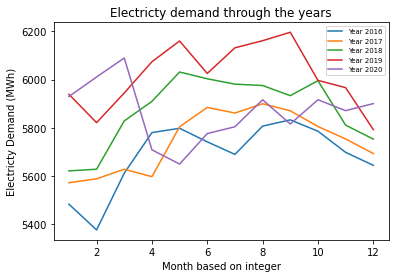

In [11]:
# DATA EXPLORATION
# I will first take a look at the general trend of the demand of electricity over the years.
# Assign...map is equivalent to mutate() in R
full_data = full_data.assign(month_year = lambda x:x['DATE'].map(lambda date:date[2:]))
#print(full_data)
summary_by_month_year = full_data.groupby(['month_year']).mean()
summary_by_month_year

years = ['2016', '2017', '2018', '2019', '2020']
for year in years:
    summary = summary_by_month_year.filter(like = year, axis = 0)
    summary = summary.assign(month = lambda x:x.index.map(lambda m_y:m_y[1:4]))
    month_dict = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    summary = summary.assign(month_int = lambda x:x['month'].map(lambda month:month_dict[month]))
    summary = summary.sort_values(by = ['month_int'])
    plt.plot(summary["month_int"], summary['DEMAND (MW)'], label = 'Year ' + year)

plt.xlabel('Month based on integer')
plt.ylabel('Electricty Demand (MWh)')
plt.title('Electricty demand through the years')
plt.legend(fontsize = 'x-small')

# From the diagram, it can be seen that generally, there is an increasing trend of electricity demand throughout the years.
# Perhaps it is due to increase in the number of houses built in Singapore? Or it could be attributed to more businesses 
# conducting/ upscaling their operations in Singapore?
# Moreover, another thing that can be seen is that throughout the years, electricity demand decreases towards the end of the
# year, ie from October to December. We can further dive into that period if we want to know what it is that caused the demand
# to decrease so much.
# Last but not least, there is an obvious anomaly from the general trend in the year 2020 from around March to April. We can 
# see that the demand of electricity for that period plummeted drastically. Perhaps it was caused by Circuit Breaker? To know
# the actual cause of it, we need more information.

In [12]:
# Pre-processing entire dataset before fitting into ML model
month_dict = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
full_data = full_data.assign(date = lambda x: x['DATE'].map(lambda date : int(date[0:2])))
full_data = full_data.assign(month = lambda x: x['DATE'].map(lambda date : date[3:6]))
full_data = full_data.assign(year = lambda x: x['DATE'].map(lambda date : int(date[7:])))

full_data = full_data.assign(month_int = lambda x: x['month'].map(lambda month : month_dict[month]))
# convert string dates in the column DATE into integer 
full_data = full_data.sort_values(['date','month_int','year'], ignore_index = True)

intermediate = full_data.assign(date_integer = lambda x: x.index.values.astype(str))
# On second thought, maybe should not use index to denote the different timings since I want to use one-hot coding. This will
# cause the number of columns to explode, potentially causing problems in the future. 

full_data = full_data.drop(['DATE', 'month', 'month_year'], axis = 1)
full_data

,PERIOD,USEP ($/MWh),TCL (MW),DEMAND (MW),LCP ($/MWh),date,year,month_int
0,1,49.45,0.0,4715.268,0.0,1,2016,1
1,2,45.63,0.0,4632.915,0.0,1,2016,1
2,3,43.23,0.0,4549.086,0.0,1,2016,1
3,4,42.10,0.0,4512.129,0.0,1,2016,1
4,5,43.23,0.0,4463.249,0.0,1,2016,1
...,...,...,...,...,...,...,...,...
87691,44,55.36,0.0,5876.414,0.0,31,2020,12
87692,45,69.15,0.0,5772.725,0.0,31,2020,12
87693,46,55.35,0.0,5661.123,0.0,31,2020,12
87694,47,68.12,0.0,5593.243,0.0,31,2020,12


<AxesSubplot:>

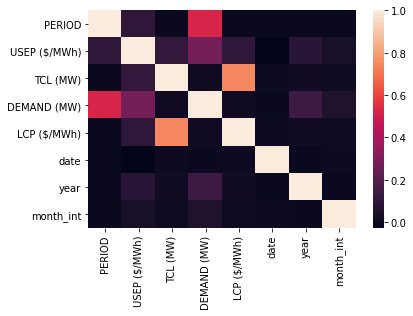

In [13]:
# Before conducting one hot encoding, I would like to check if there are any variables that are linearly correlated to each other.
# From there, if there are linearly related variables, I will decide whether to remove any variable.
sns.heatmap(full_data.corr())
# It seems that TCL (MW) is quite closely correlated to LCP but that is not a huge problem. Hence, I will just leave the 
# variables as is for now.

In [14]:
#One Hot Encoding for categorical variables
period_dummy = pd.get_dummies(full_data['PERIOD'])
date_dummy = pd.get_dummies(full_data['date'])
year_dummy = pd.get_dummies(full_data['year'])
month_dummy = pd.get_dummies(full_data['month_int'])
full_data = pd.concat([full_data, period_dummy, date_dummy, year_dummy, month_dummy], axis = 1)
# converting the 8th column onwards to categorical column since integer column implies a certain 
# kind of order 
full_data.iloc[:,8:] = full_data.iloc[:,8:].astype('category') 

In [15]:
# Splitting will be done as such : 2020 will be used as the testing data and 2016 to 2019 data will be the training and validation
# data
# The model will be produced as such: 
# year_2016_to_2019 will be split into training and validation data : 0.8 train and 0.2 validate
year_2016_to_2019 = full_data[(full_data['year'] == 2016) | (full_data['year'] == 2017) | (full_data['year'] == 2018) | (full_data['year'] == 2019)]
year_2020 = full_data[(full_data['year'] == 2020)]
year_2016_to_2019 = year_2016_to_2019.drop(['PERIOD','date', 'year', 'month_int'], axis = 1)
year_2020 = year_2020.drop(['PERIOD','date', 'year', 'month_int'], axis = 1)

In [16]:
y_train_and_validation = year_2016_to_2019['DEMAND (MW)']
X_train_and_validation_intermediate = year_2016_to_2019.drop(['DEMAND (MW)'], axis = 1)

# Split data set before doing any kind of scaling 
X_train_intermediate, X_val_intermediate, y_train, y_val = train_test_split(X_train_and_validation_intermediate, y_train_and_validation, test_size = 0.2) 

y_test = year_2020['DEMAND (MW)']
X_test_intermediate = year_2020.drop(['DEMAND (MW)'], axis = 1)

# We have to scale the various continuous variables as they are all of different units.
# Scaling for X_train
X_train = X_train_intermediate.copy()
usep = X_train["USEP ($/MWh)"]
arr = np.array(usep)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
usep = scaler.transform(newarr)
X_train["USEP ($/MWh)"] = usep

tcl = X_train["TCL (MW)"]
arr = np.array(tcl)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
tcl = scaler.transform(newarr)
X_train["TCL (MW)"] = tcl

lcp = X_train["LCP ($/MWh)"]
arr = np.array(lcp)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
lcp = scaler.transform(newarr)
X_train["LCP ($/MWh)"] = lcp


# Scaling for X_val
X_val = X_val_intermediate.copy()
features = X_val["USEP ($/MWh)"]
arr = np.array(features)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
features = scaler.transform(newarr)
X_val["USEP ($/MWh)"] = features

tcl = X_val["TCL (MW)"]
arr = np.array(tcl)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
tcl = scaler.transform(newarr)
X_val["TCL (MW)"] = tcl

lcp = X_val["LCP ($/MWh)"]
arr = np.array(lcp)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
lcp = scaler.transform(newarr)
X_val["LCP ($/MWh)"] = lcp


# Scaling for X_test
X_test = X_test_intermediate.copy()
features = X_test["USEP ($/MWh)"]
arr = np.array(features)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
features = scaler.transform(newarr)
X_test["USEP ($/MWh)"] = features

tcl = X_test["TCL (MW)"]
arr = np.array(tcl)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
tcl = scaler.transform(newarr)
X_test["TCL (MW)"] = tcl

lcp = X_test["LCP ($/MWh)"]
arr = np.array(lcp)
newarr = arr.reshape(-1,1)
scaler = StandardScaler().fit(newarr)
lcp = scaler.transform(newarr)
X_test["LCP ($/MWh)"] = lcp


In [17]:
# We will begin fitting a model and attempt to get the best model. Note that we will not be going through RandomForestRegressor, Linear
# Regression and linear kernel for SVR as they are not good at extrapolating data points.

svr = SVR(kernel='poly', C = 21)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
score = sqrt(mean_squared_error(y_val, y_pred))
print(score)

# RMSE : 374.5393837387467 for poly kernel with C = 21
# RMSE : 339.5089218733055 for poly kernel with C = 23
# RMSE : 380.82657709642183 for poly kernel with C = 25
# Best regularisation term : C = 23

374.5393837387467


In [17]:
svr = SVR(kernel='rbf', C = 9)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
score = sqrt(mean_squared_error(y_val, y_pred))
print(score)

# RMSE : 339.70443695010124 for poly kernel with C = 9
# RMSE : 335.39973517914393 for rbf kernel with C = 11 
# RMSE : 336.4618508099766 for rbf kernel with C = 13 
# Best regularisation term : C = 11

339.70443695010124


In [18]:
svr = SVR(kernel='sigmoid', C = 2)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
score = sqrt(mean_squared_error(y_val, y_pred))
print(score)
# RMSE : 595.6221688329035 for sigmoid kernel with C = 1
# RMSE : 894.7138743513303 for sigmoid kernel with C = 2
# Best regularisation term : C = 1

894.7138743513303


In [20]:
n_choices = [1,3,5,7,9,11,13,15,17,19,21]
fin = []
for i in n_choices:
  model2 = KNeighborsRegressor(n_neighbors = i)
  model2.fit(X_train, y_train)
  y_pred = model2.predict(X_test)
  rmse = sqrt(mean_squared_error(y_test, y_pred))
  toap = [i, rmse]
  fin.append(toap)

print(fin)
mx = min(fin, key = lambda x: x[1])
val_rmse = mx[1]
n = mx[0]
print(val_rmse)
print(n)

# The best number of neighbours for KNearestRegresors is 21. RMSE : 307.3264927419669

[[1, 445.3054752834596], [3, 355.53150828596233], [5, 336.4733012112046], [7, 325.2966806506338], [9, 319.0721796814851], [11, 315.5790832050743], [13, 312.7987360546037], [15, 310.9459531712995], [17, 309.39842138932534], [19, 308.20604555967606], [21, 307.3264927419669]]
307.3264927419669
21


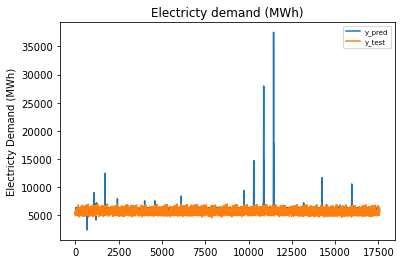

In [18]:
# From the models that we have so far, we can see that KNearestRegressors has the lowest RMSE. However, to test the reliability
# of the model, I would like to plot a graph showcasing the predicted values vs actual values for test set when this model
# is used. 
# plotting y_pred vs y_test using KNearestNeighbours
model2 = KNeighborsRegressor(n_neighbors = 21)
model2.fit(X_train,y_train)
y_pred = svr.predict(X_test)

y_pred2 = pd.DataFrame(y_pred)
y_pred2 = y_pred2.assign(index = lambda x : x.index)
plt.plot(y_pred2['index'],y_pred2[0], label = 'y_pred')

y_test2 = pd.DataFrame(y_test)
y_test2 = y_test2.reset_index(drop = True)
y_test2 = y_test2.assign(index = lambda x : x.index)
plt.plot(y_test2['index'],y_test2['DEMAND (MW)'], label = 'y_test')

plt.ylabel('Electricty Demand (MWh)')
plt.title('Electricty demand (MWh)')
plt.legend(fontsize = 'x-small')
# From the plot, we can see that the predicted vs actual plots are not very obvious. As such, I will plot the difference 
# between the actual and predicted plots.

Text(0, 0.5, 'Electricity Demand (MWh)')

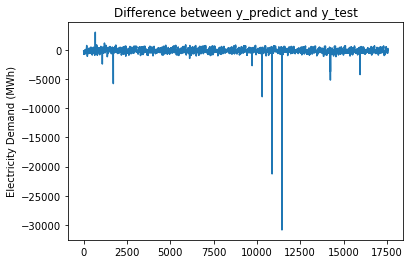

In [19]:
diff = pd.DataFrame(y_test2['DEMAND (MW)'] - y_pred2[0])
diff = diff.assign(index = lambda x:x.index)
plt.plot(diff['index'], diff[0])
plt.title('Difference between y_predict and y_test')
plt.ylabel('Electricity Demand (MWh)')
# As we can see, even though KNearestNeighbors has the lowest RMSE, the prediction for the test set is quite poor at times.

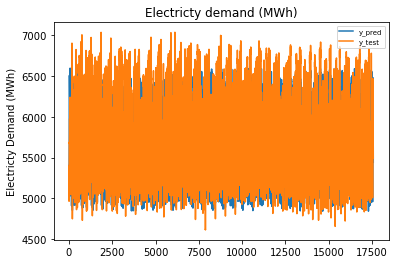

In [20]:
# From the models that we have so far, we can see that SVR (rbf kernel) has the 2nd lowest RMSE. However, to test the reliability
# of the model, I would like to plot a graph showcasing the predicted values vs actual values for test set when this model
# is used. 
# plotting y_pred vs y_test using SVR (rbf kernel and regularisation = 11)
svr = SVR(kernel='rbf', C = 11)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)

y_pred2 = pd.DataFrame(y_pred)
y_pred2 = y_pred2.assign(index = lambda x : x.index)
plt.plot(y_pred2['index'],y_pred2[0], label = 'y_pred')

y_test2 = pd.DataFrame(y_test)
y_test2 = y_test2.reset_index(drop = True)
y_test2 = y_test2.assign(index = lambda x : x.index)
plt.plot(y_test2['index'],y_test2['DEMAND (MW)'], label = 'y_test')

plt.ylabel('Electricty Demand (MWh)')
plt.title('Electricty demand (MWh)')
plt.legend(fontsize = 'x-small')
# From the plot, we can see that the predicted vs actual plots are not very obvious. As such, I will plot the difference 
# between the actual and predicted plots.

Text(0, 0.5, 'Electricity Demand (MWh)')

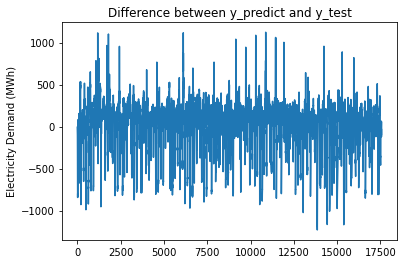

In [21]:
diff = pd.DataFrame(y_test2['DEMAND (MW)'] - y_pred2[0])
diff = diff.assign(index = lambda x:x.index)
plt.plot(diff['index'], diff[0])
plt.title('Difference between y_predict and y_test')
plt.ylabel('Electricity Demand (MWh)')

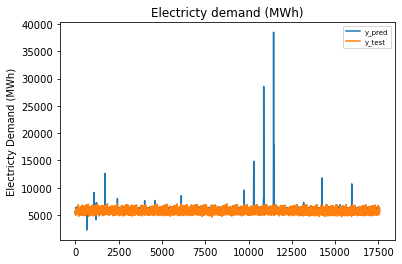

In [22]:
# As such, I will attempt to use the model that has the 3rd lowest RMSE, i.e., I will use SVR (poly kernel) with C = 31.
svr = SVR(kernel='poly', C = 23)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)

y_pred2 = pd.DataFrame(y_pred)
y_pred2 = y_pred2.assign(index = lambda x : x.index)
plt.plot(y_pred2['index'],y_pred2[0], label = 'y_pred')

y_test2 = pd.DataFrame(y_test)
y_test2 = y_test2.reset_index(drop = True)
y_test2 = y_test2.assign(index = lambda x : x.index)
plt.plot(y_test2['index'],y_test2['DEMAND (MW)'], label = 'y_test')

plt.ylabel('Electricty Demand (MWh)')
plt.title('Electricty demand (MWh)')
plt.legend(fontsize = 'x-small')
# From the plot, we can see that the predicted vs actual plots are not very obvious. As such, I will plot the difference 
# between the actual and predicted plots.

Text(0, 0.5, 'Electricity Demand (MWh)')

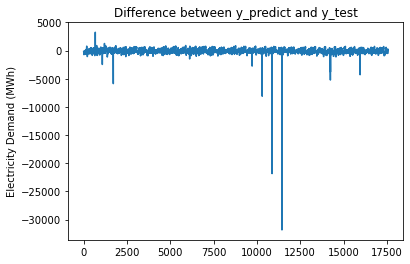

In [23]:
# y_test2 and y_pred2 used in this case are obtained from the SVR (poly kernel)
diff = pd.DataFrame(y_test2['DEMAND (MW)'] - y_pred2[0])
diff = diff.assign(index = lambda x:x.index)
plt.plot(diff['index'], diff[0])
plt.title('Difference between y_predict and y_test')
plt.ylabel('Electricity Demand (MWh)')

# From the graphs, we can see that SVR (rbf kernel) seems to perform the best, as seen from the predictions being +- 500 MW 
# from the actual test values. Furthermore, even though there are times the predictions are not as good, they do not occur
# very frequently, and the difference is not too large. 